In [1]:
from models.mnist_classifier.lenet import LeNet5, LeNet1, LeNet5_channel3
from torchvision.datasets import SVHN
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import random
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms,utils,datasets
import numpy as np
from torch import optim
import time
import torchvision.models as models
from pylab import *

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/SVHN'
mean = [0.4377, 0.4438, 0.4728]
std = [0.1980, 0.2010, 0.1970]
data_train = SVHN(data_root,
                   split='train',
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]))
data_test = SVHN(data_root,
                  split='test',
                  download=True,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]))

Using downloaded and verified file: ./autodl-tmp/SVHN/train_32x32.mat
Using downloaded and verified file: ./autodl-tmp/SVHN/test_32x32.mat


In [3]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [4]:
net = LeNet5_channel3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)  #学习率，太高如2e-3会立马收敛，cagfuzz里设置为0.05

In [5]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    # 每一轮结束输出一下当前的学习率 lr
    lr_1 = optimizer.param_groups[0]['lr']
    print("learn_rate:%.15f" % lr_1)
    # schedule.step()
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [6]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [7]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [8]:
epoch = 100
acc, loss, val_acc, val_loss = [], [], [], []

start = time.time()
for e in range(epoch):
    #if e>=20 and e<50:
     #   optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.001)
    #elif e>=50:
     #   optimizer = ooptim.SGD(net.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.001)
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')
    if e % 10 == 0:
        torch.save(net.state_dict(), f'autodl-tmp/save_model/svhn/lenet5/epoch={e}_test_acc={c:0.3f}.pth')
end = time.time()
# 计算并打印输出你的训练时间
print("total time:{}".format(end - start))

training...
learn_rate:0.000100000000000
Train Avg. Loss: 2.206941, Accuracy: 0.207666
Test Avg. Loss: 1.976204, Accuracy: 0.352604
lenet_epoch=0 test_acc=0.353
training...
learn_rate:0.000100000000000
Train Avg. Loss: 1.588316, Accuracy: 0.502150
Test Avg. Loss: 1.213394, Accuracy: 0.626613
lenet_epoch=1 test_acc=0.627
training...
learn_rate:0.000100000000000
Train Avg. Loss: 1.077094, Accuracy: 0.682133
Test Avg. Loss: 0.931625, Accuracy: 0.738476
lenet_epoch=2 test_acc=0.738
training...
learn_rate:0.000100000000000
Train Avg. Loss: 0.870978, Accuracy: 0.750454
Test Avg. Loss: 0.811943, Accuracy: 0.770513
lenet_epoch=3 test_acc=0.771
training...
learn_rate:0.000100000000000
Train Avg. Loss: 0.767042, Accuracy: 0.782383
Test Avg. Loss: 0.745552, Accuracy: 0.797019
lenet_epoch=4 test_acc=0.797
training...
learn_rate:0.000100000000000
Train Avg. Loss: 0.699388, Accuracy: 0.801371
Test Avg. Loss: 0.701166, Accuracy: 0.808851
lenet_epoch=5 test_acc=0.809
training...
learn_rate:0.000100000

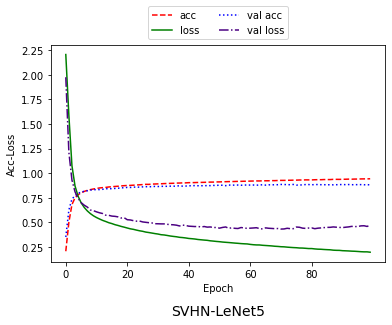

In [9]:
x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('SVHN-LeNet5', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [14]:
val_acc

[0.3526044867854948,
 0.6266133988936693,
 0.7384757221880762,
 0.7705132145052244,
 0.797019053472649,
 0.8088506453595574,
 0.816840811309158,
 0.8224108789182545,
 0.8295559311616472,
 0.8325906576521205,
 0.8342808850645359,
 0.8342808850645359,
 0.8371235402581438,
 0.8438076213890596,
 0.8421173939766441,
 0.8443838352796558,
 0.8460740626920713,
 0.847879532882606,
 0.8528349723417332,
 0.8518746158574063,
 0.8567148125384143,
 0.8559081130915795,
 0.8586739397664414,
 0.8607098955132145,
 0.8583282114320836,
 0.8619775660725261,
 0.8635909649661955,
 0.8640135218192994,
 0.8635525507068224,
 0.866779348494161,
 0.8655116779348494,
 0.8668561770129072,
 0.8678549477566072,
 0.8672787338660111,
 0.8690073755377996,
 0.8683927473878303,
 0.8705055316533498,
 0.8732329440688383,
 0.8692378610940381,
 0.8700829748002459,
 0.8730792870313461,
 0.8726567301782422,
 0.8752688998156115,
 0.8733866011063307,
 0.8737707437000615,
 0.8731945298094653,
 0.8751536570374924,
 0.87453902888752

In [15]:
val_loss

[1.9762035608291626,
 1.2133941650390625,
 0.9316245913505554,
 0.8119429349899292,
 0.7455517053604126,
 0.7011659145355225,
 0.6756100654602051,
 0.6565635800361633,
 0.6265246868133545,
 0.6199305653572083,
 0.6078372001647949,
 0.5981419086456299,
 0.5907996296882629,
 0.573941707611084,
 0.5724248290061951,
 0.5647444725036621,
 0.5622991323471069,
 0.5567745566368103,
 0.5453782081604004,
 0.5480338931083679,
 0.5279918313026428,
 0.5255327224731445,
 0.5182697176933289,
 0.5131850242614746,
 0.514478325843811,
 0.5054850578308105,
 0.501617431640625,
 0.4980447292327881,
 0.4953294098377228,
 0.48743462562561035,
 0.4868262708187103,
 0.4857093393802643,
 0.48552200198173523,
 0.48141372203826904,
 0.4780542254447937,
 0.4764457643032074,
 0.47252196073532104,
 0.4645744264125824,
 0.47324472665786743,
 0.4694763720035553,
 0.4623356759548187,
 0.46058616042137146,
 0.45851263403892517,
 0.460088849067688,
 0.45339661836624146,
 0.4590056836605072,
 0.4527738392353058,
 0.454581

In [16]:
acc

[0.20766616159547893,
 0.5021499651910397,
 0.6821327654695114,
 0.7504538815403307,
 0.7823825709488513,
 0.8013705174932089,
 0.8158674256385056,
 0.8261326562649303,
 0.8338452298073904,
 0.8404521069658872,
 0.8454755176979675,
 0.8510449513357086,
 0.854089029034768,
 0.8564915298196759,
 0.8610235199366614,
 0.8634806230121354,
 0.8661288341045907,
 0.8684494314536495,
 0.8715344608706336,
 0.874005214518749,
 0.8760801015602605,
 0.877008340499884,
 0.8789194206696971,
 0.8811444640102652,
 0.8829872913168707,
 0.8851577323668728,
 0.8876557871602714,
 0.8872326194083842,
 0.8903312993980097,
 0.8910547797480104,
 0.8924061864395212,
 0.8934572805329184,
 0.8951089998225426,
 0.8963512019329211,
 0.897525151180092,
 0.8984533901197155,
 0.900241615135755,
 0.900896842622548,
 0.902384755040474,
 0.9025622124848137,
 0.9046370995263251,
 0.9048828098338725,
 0.9056062901838732,
 0.9067938900036857,
 0.907326262336705,
 0.9080087909687812,
 0.9093601976602919,
 0.9103430388904814,

In [17]:
loss

[2.206940662570116,
 1.5883159363311343,
 1.077093883466222,
 0.8709776989258956,
 0.7670416613904442,
 0.699387908397236,
 0.6526675883693562,
 0.6174908106958409,
 0.5898707608728043,
 0.5676286839441971,
 0.5499029574909277,
 0.5349778984689546,
 0.5210072587695271,
 0.5098797963471363,
 0.49741164992079917,
 0.48865851739142413,
 0.47757696523898985,
 0.46953355788353845,
 0.46004336594704553,
 0.4523754548735735,
 0.44369594986430444,
 0.4354691379784707,
 0.4301224612608189,
 0.4224478071782647,
 0.4154375014820165,
 0.41021919769692505,
 0.4024706506251458,
 0.39778001855682416,
 0.3924644162638262,
 0.38698712728580115,
 0.382427674085421,
 0.3756491528363178,
 0.3730089981693009,
 0.3679434580254638,
 0.36243241905958395,
 0.3583146012826248,
 0.35468636255854097,
 0.34910773909050413,
 0.34643986712141733,
 0.3425928993922908,
 0.337573376941764,
 0.33495865326102187,
 0.3317741317096903,
 0.3270513957385818,
 0.324078835624851,
 0.3210892992464092,
 0.3186091565192784,
 0.31